# RNN LSTM Model trained on 6 years of price history and /r/Bitcoin Posts

> In this notebook I will be doing the final step of my project: modeling. Using the Keras library, I'll be combing Dense, Dropout, and LSTM layers to model on top of my price and sentiment data

---

# Imports and data clarity

In [4]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(4234) #The random seed I chose was basically button mash - it has no broader meaning.

In [5]:
# data originally contained one line of description text. I've removed that for ease of use.
df = pd.read_csv('/Users/zoenawar/DSI/RNN_LSTM_Cryptocurrency_Project/datasets/bitcoin_modeling_dataset.csv')

### A brief look at the data to make sure everything is in place.

In [6]:
df.head() 

,Date,Open,High,Low,Close,Target,compound,neg,neu,pos
0,2013-10-12,0.000000,0.013030,0.000000,0.009058,1,0.277209,0.035028,0.860241,0.104769
1,2013-10-13,0.009058,0.034039,0.009058,0.038110,2,0.236865,0.041686,0.833769,0.124545
2,2013-10-14,0.038110,0.028444,0.038110,0.028444,2,0.224255,0.040007,0.804474,0.155482
3,2013-10-15,0.028444,0.128402,0.015473,-0.012612,0,0.424886,0.056941,0.735112,0.207753
4,2013-10-16,-0.012612,-0.044837,0.000000,0.028085,2,0.296233,0.054215,0.802395,0.143270


In [7]:
df.tail()

,Date,Open,High,Low,Close,Target,compound,neg,neu,pos
2018,2019-05-04,0.050093,0.007591,0.029113,0.018286,2,0.119783,0.042390,0.866733,0.090913
2019,2019-05-05,0.018286,-0.010291,0.018570,-0.008085,1,0.162901,0.045594,0.855210,0.099217
2020,2019-05-06,-0.008085,-0.004827,-0.011408,-0.005160,1,0.197224,0.020690,0.892975,0.086318
2021,2019-05-07,-0.005160,0.035431,0.022289,0.038559,2,0.075152,0.061358,0.818551,0.120079
2022,2019-05-08,0.009952,0.004601,-0.004818,0.005570,1,0.022512,0.071135,0.857285,0.067715


In [8]:
df.shape

(2023, 10)

In [9]:
df.dtypes

Date         object
Open        float64
High        float64
Low         float64
Close       float64
Target        int64
compound    float64
neg         float64
neu         float64
pos         float64
dtype: object

In [10]:
df.set_index('Date', inplace=True) #Making sure the index is datetime.

## Model Preperation

> In the following lines, I will be organizing, scaling, and splitting the data to prepare it for the model.

In [11]:
# Setting my x and y to all the non-target features and target respectively 
features = [col for col in df.columns if not col == 'Target'] 
X = df[features]
y = df[['Target']].values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False) # Train test splitting
X_train.head()

,Open,High,Low,Close,compound,neg,neu,pos
Date,,,,,,,,
2013-10-12,0.000000,0.013030,0.000000,0.009058,0.277209,0.035028,0.860241,0.104769
2013-10-13,0.009058,0.034039,0.009058,0.038110,0.236865,0.041686,0.833769,0.124545
2013-10-14,0.038110,0.028444,0.038110,0.028444,0.224255,0.040007,0.804474,0.155482
2013-10-15,0.028444,0.128402,0.015473,-0.012612,0.424886,0.056941,0.735112,0.207753
2013-10-16,-0.012612,-0.044837,0.000000,0.028085,0.296233,0.054215,0.802395,0.143270


In [13]:
# Our data works on multiple scales, so it's neccessary to scale it before feeding it into the model
ss = StandardScaler()
X_train_sc = ss.fit_transform(np.nan_to_num(X_train))
X_test_sc = ss.transform(np.nan_to_num(X_test))

In [14]:
#generation of training sequences
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)

In [15]:
batch_x, batch_y = train_sequences[0]

In [16]:
batch_x.shape

(64, 3, 8)

In [17]:
batch_y.shape

(64, 1)

In [18]:
pd.DataFrame(X_train_sc, columns=X_train.columns).head(3)

,Open,High,Low,Close,compound,neg,neu,pos
0,-0.088831,0.200052,-0.084073,0.109833,2.208490,-1.084701,0.102764,0.539941
1,0.112844,0.668930,0.090744,0.753752,1.514672,-0.529072,-1.194896,1.515347
2,0.759718,0.544046,0.651470,0.539501,1.297814,-0.669157,-2.630891,3.041135


In [19]:
#generation of test sequences

test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=3, batch_size=64)

# Model building and compiling

> In the following lines I set out the many layers in my model, using LSTM, dropout, and Dense layers to train my model. Then I compile the model and record the history for analysis.

In [20]:
model = Sequential()
model.add(LSTM(8, input_shape=(3, 8), return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(8))

model.add(Dropout(0.3))

model.add(Dense(6, activation='relu'))

model.add(Dropout(0.3))

model.add(Dense(4, activation='relu'))

model.add(Dropout(0.3))


model.add(Dense(3, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
model.compile(optimizer=Adam(lr=.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

history = model.fit_generator(train_sequences, validation_data=test_sequences, epochs=100, verbose=0)

Instructions for updating:
Use tf.cast instead.


# Checking out the model

> In the following section I take a look at the Loss scores and Accuracy of the model as it trains

In [22]:
# history.history['loss']

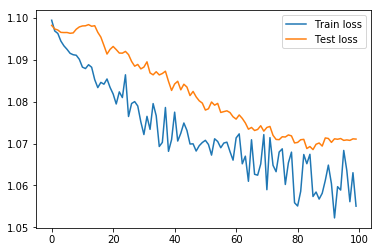

In [23]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.legend();

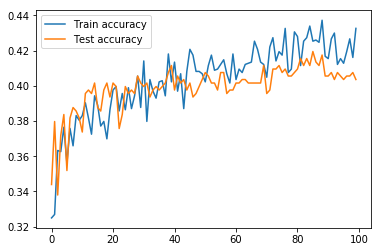

In [24]:
plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Test accuracy')
plt.legend();

In [25]:
df.Target.value_counts(normalize=True) # The baseline is .36 as that's the dominant class

1    0.363322
2    0.350470
0    0.286209
Name: Target, dtype: float64

# Conclusion

For the most part, I'm pretty happy with this model. I think the fact that it performs consistently with minimal overfitting and no drastic variation is an achievement in itself. But, as expected, it's very difficult to build high performance models to predict markets. The level of volatility and the black box nature of markets makes it incredibly difficult to do feature selection, and while using sentiment analysis on reddit was an interesting idea it won't be getting anyone rich anytime soon.

In the future I plan to expand this model to include more subreddits, more complicated price history, and adjust the model topology to see if I can optimize performance. 